In [1]:
import os
import cv2
import pandas
import numpy as np
import matplotlib.pyplot as plt

def clipped(im):
    h, w, _ = im.shape
    #nh, nw = (h-66)//2, (w-200)//2
    #im = im[nh:nh+66, nw:nw+200, :]
    im = im[h//3:h-30, :w, :]
    return im

def extract_image(f):
    im = cv2.imread(f)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2YUV)
    im = clipped(im)
    im = im[:,:,0:1]
    return im

def process_db(dir):
    with open(os.path.join(dir, 'driving_log.csv'), 'r') as f:
        data = pandas.read_csv(f, header=0, skipinitialspace=True)
        res = np.asarray(data.values)
        c, l, r, st, t, b, sp = np.split(res, 7, axis=1)
        l = np.array([extract_image(os.path.join(dir, p)) for p in l.squeeze()])
        c = np.array([extract_image(os.path.join(dir, p)) for p in c.squeeze()])
        r = np.array([extract_image(os.path.join(dir, p)) for p in r.squeeze()])        
        return l, c, r, st.squeeze().astype(np.float32)
        
l, c, r, st = process_db('../data')
print(c.shape)

(8036, 77, 320, 1)


(8596, 77, 320, 1) (8596,)


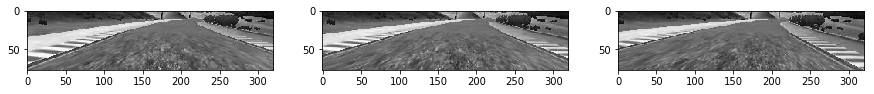

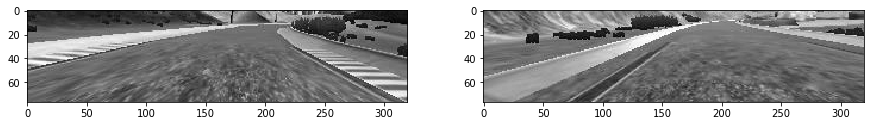

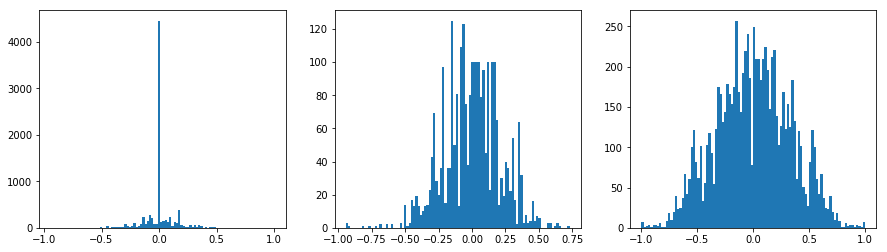

In [33]:
%matplotlib inline

def distribution(ar, bins=100):
    h, b = np.histogram(ar, bins)
    r = np.digitize(st, b)
    return r, np.bincount(r)

def old_balance_data(st, c, l, r):
    limit = 0.10
    extreme = np.logical_or(st<-limit, st>limit)
    normal = np.logical_and(st>=-limit, st<=limit)
    nb_normal = 500
    nb_extreme = 2000
    print(len(st[normal]), len(st[extreme]))
    bal_st = np.append(st[normal][:nb_normal], st[extreme][:nb_extreme])
    bal_c = np.append(c[normal][:nb_normal], c[extreme][:nb_extreme], axis=0)
    bal_l = np.append(l[normal][:nb_normal], l[extreme][:nb_extreme], axis=0)
    bal_r = np.append(r[normal][:nb_normal], r[extreme][:nb_extreme], axis=0)
    return bal_st, bal_c, bal_l, bal_r

def balance_data(st, c, l, r, n=100, bins=100):
    dist, _ = distribution(st)
    bal_st = np.concatenate([st[dist==rng][:n] for rng in range(bins)])
    bal_c = np.concatenate([c[dist==rng][:n, :, :, :] for rng in range(bins)])
    bal_l = np.concatenate([l[dist==rng][:n, :, :, :] for rng in range(bins)])
    bal_r = np.concatenate([r[dist==rng][:n, :, :, :] for rng in range(bins)])
    return bal_st, bal_c, bal_l, bal_r

bal_st, bal_c, bal_l, bal_r = balance_data(st, c, l, r, 100, 100)

f = plt.figure(figsize=(15,4))
f.add_subplot(1,3,1).imshow(bal_l[-1].squeeze(), cmap='gray')
f.add_subplot(1,3,2).imshow(bal_c[-1].squeeze(), cmap='gray')
f.add_subplot(1,3,3).imshow(bal_r[-1].squeeze(), cmap='gray')

features = bal_c
labels = bal_st

features = np.append(features, bal_l, axis=0)
features = np.append(features, bal_r, axis=0)
labels = np.append(labels, bal_st+0.25, axis=0)
labels = np.append(labels, bal_st-0.25, axis=0)

flip = np.logical_or(labels<-0.5, labels>0.5)

f = plt.figure(figsize=(15,4))
f.add_subplot(1,2,1).imshow(features[-1].squeeze(), cmap='gray')

features = np.append(features, [np.fliplr(f) for f in features[flip]], axis=0)
labels = np.append(labels, -labels[flip])

f.add_subplot(1,2,2).imshow(features[-1].squeeze(), cmap='gray')

labels = np.clip(labels, -1., 1.)

f = plt.figure(figsize=(15,4))
_ = f.add_subplot(1,3,1).hist(st, 100)
_ = f.add_subplot(1,3,2).hist(bal_st, 100)
_ = f.add_subplot(1,3,3).hist(labels, 100)

print(features.shape, labels.shape)



In [34]:

labels = labels.astype(np.float32)
features = features.astype(np.float32)

mn = np.min(features, axis=(1,2,3), keepdims=True)
mx = np.max(features, axis=(1,2,3), keepdims=True)
rng = (mx - mn)
features -= mn
features = features/rng

X_train, y_train = features, labels
print(X_train.shape, y_train.shape)



(8596, 77, 320, 1) (8596,)


In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.wrappers.scikit_learn import KerasRegressor

from keras.layers.pooling import MaxPooling2D
import numpy as np
from random import random

def my_model():
    model = Sequential()
    model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu', name='c1', input_shape=(77, 320, 1)))
    model.add(MaxPooling2D((2,2)))
    #model.add(Dropout(0.5))
    model.add(Convolution2D(64, 5, 5, border_mode='same', activation='relu', name='c2'))
    model.add(MaxPooling2D((2,2)))
    #model.add(Dropout(0.5))    
    model.add(Convolution2D(128, 5, 5, border_mode='same', activation='relu', name='c3'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.5))    

    model.add(Flatten())
    model.add(Dense(512, name='d1'))
    model.add(Dense(64, name='d2'))
    model.add(Dense(16, name='d3'))
    model.add(Dense(1, name='out'))
    
    return model

def nvidia_model():
    model = Sequential()
    model.add(Convolution2D(24, 5, 5, border_mode='same', activation='relu', name='c1', subsample=(2,2), input_shape=(160, 320, 1)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(36, 5, 5, border_mode='same', activation='relu', name='c2', subsample=(2,2)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(48, 5, 5, border_mode='same', activation='relu', name='c3', subsample=(2,2)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', name='c4'))
    model.add(Dropout(0.2))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', name='c5'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1164, name='d1'))
    model.add(Dense(100, name='d2'))
    model.add(Dense(50, name='d3'))
    model.add(Dense(10, name='d4'))
    model.add(Dense(1, name='out'))

    return model


model = my_model()
model.compile('adam', 'mse')
history = model.fit(X_train, y_train, batch_size=32, nb_epoch=3, verbose=2, validation_split=0.2)
y_pred = model.predict(X_train)

print(model.save("model.mine.h5"))


Train on 6876 samples, validate on 1720 samples
Epoch 1/3
915s - loss: 6.7162 - val_loss: 0.0868
Epoch 2/3
1156s - loss: 0.0419 - val_loss: 0.0785
Epoch 3/3


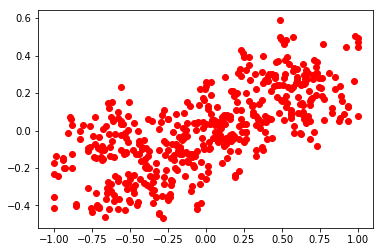

In [32]:
plt.plot(y_train, y_pred, 'ro')


In [ ]:
# balancing data
# different network model
# regularization
# all colour channels
# normalization it's own layer

# crop
# extrapolate
# visualize
